# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

## 1. Explore the Environment

First part of the notebook introduces Unity Banana enviroment and lets you explore its state and actions spaces


### 1.1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

### 1.2. Create Unity environment wrapper

We need to create Environment wrapper which allows our agent to communicate with Unity environment in an easy way. Just simplifying interface.

In [2]:
class EnvironmentWrapper():
    def __init__(self, file_name):
        self.env = UnityEnvironment(file_name=file_name, worker_id=1)
        self.brain_name = self.env.brain_names[0]
        self.brain = self.env.brains[self.brain_name]
        self.action_size = self.brain.vector_action_space_size
        
        self.env_info = self.env.reset(train_mode=False)[self.brain_name]
        state = self.env_info.vector_observations[0]
        self.state_size = len(state)
        
    def reset(self, train_mode=False):
        self.env_info = self.env.reset(train_mode=train_mode)[self.brain_name]
        state = self.env_info.vector_observations[0]
        
        return state
        
    def close(self):
        self.env.close()
        
    def step(self, action):
        action = action.astype(np.int32)
        self.env_info = self.env.step(action)[self.brain_name]       
        next_state = self.env_info.vector_observations[0]   
        reward = self.env_info.rewards[0]                   
        done = self.env_info.local_done[0]                
        return next_state, reward, done

In [3]:
env = EnvironmentWrapper(file_name="Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.env.brain_names[0]
brain = env.env.brains[brain_name]

### 1.2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [0.         1.         0.         0.         0.16895212 0.
 1.         0.         0.         0.20073597 1.         0.
 0.         0.         0.12865657 0.         1.         0.
 0.         0.14938059 1.         0.         0.         0.
 0.58185619 0.         1.         0.         0.         0.16089135
 0.         1.         0.         0.         0.31775284 0.
 0.        ]
States have length: 37


### 1.3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [6]:
env_info = env.env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 2.0


## 2. Train Deep Q-Learning Agent

Now it's time to train agent to solve the environment!  When training the environment.  We implemented Deep Q-learning with experience replay algorithm described in the Deep Mind paper:
https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf
The difference from the original work is that their agent was trained from the raw screen input so Convolutional Q Network was used for training. We implemented slightly simplified version which requires state vector shape = (37) instead of raw pixel data so we used Fully-Connected Q-Network instead.

### 2.1. Import PyTorch

First we need to import PyTorch library so we can start building Deep Q network to make agent learn from expirience. Here is a good instructions how PyTorch should be installed: https://github.com/williamFalcon/pytorch-gpu-install

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### 2.2. Setup Q-Network Archtiectures

We ended up with simple three layers Fully connected network with Relu as activation functions. Dropout regularization is also used to improve Network generalization. Second network (DuelingQNetwork) is network which setup to cover Dueling DQN described in the paper: https://arxiv.org/abs/1511.06581

In [8]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.action_size = action_size
        self.state_size =  state_size
        
        self.fc1 = nn.Linear(self.state_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, self.action_size)
        
    def forward(self, state):
        """Build a network that maps state -> action values."""
        # final output
        x = F.relu(self.fc1(state))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.fc3(x)     
        
        return x
    
    
class DuelingQNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(DuelingQNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.action_size = action_size
        self.state_size =  state_size
        
        self.fc1 = nn.Linear(self.state_size, 128)
        
        self.fc2value = nn.Linear(128, 64)
        self.fc3value = nn.Linear(64, 1)
        
        self.fc2action = nn.Linear(128, 64)
        self.fc3action = nn.Linear(64, self.action_size)
        
    def forward(self, state):
        # featrues layer
        features = F.relu(self.fc1(state))
        
        # value layer
        values = F.relu(self.fc2value(features))
        values = F.dropout(values, p=0.2, training=self.training)
        values = self.fc3value(values)     
        
        # actions layer
        actions = F.relu(self.fc2action(features))
        actions = F.dropout(actions, p=0.2, training=self.training)
        actions = self.fc3action(actions)     
        
        # compined result
        return values + actions - actions.mean()

### 2.3. Create Expirience Replay Buffer

We need to define class with will be used to store experience tuples.

In [9]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### 2.4. Create base  agent

Create base agent class which will be used for additional modifications like Double DQN and Dueling DQN 

In [10]:
from collections import namedtuple, deque
import random

# hyper params sample
hyperparams = { "BUFFER_SIZE" : int(1e5),  # replay buffer size
                "BATCH_SIZE" : 64,         # minibatch size
                "GAMMA" : 0.99,            # discount factor
                "TAU" : 1e-3,              # for soft update of target parameters
                "LR" : 5e-4,               # learning rate 
                "UPDATE_EVERY" : 4,        # how often to update the network
                "UPDATE_TARGET_EVERY" : 4  # how often to update target network 
              }

class BaseAgent():
    """Interacts with and learns from the environment."""

    def __init__(self, device, hyperparams, qNetwork, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.hyperparams = hyperparams
        
        self.device = device
           
        self.BUFFER_SIZE = hyperparams["BUFFER_SIZE"]
        self.BATCH_SIZE = hyperparams["BATCH_SIZE"]
        self.GAMMA = hyperparams["GAMMA"]
        self.TAU = hyperparams["TAU"]
        self.LR = hyperparams["LR"]
        
        self.UPDATE_EVERY = hyperparams["UPDATE_EVERY"]
        self.UPDATE_TARGET_EVERY = hyperparams["UPDATE_TARGET_EVERY"]
        
        self.state_size = state_size
        
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        # Deep Q-Learning Algorithm: Initialize parameters W of Q network
        self.qnetwork_local = qNetwork(state_size, action_size, seed).to(self.device)
        
        # Deep Q-Learning Algorithm: Initialize parameters W-
        self.qnetwork_target = qNetwork(state_size, action_size, seed).to(self.device)
        self.qnetwork_target.eval()
        
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=self.LR)

        # Deep Q-Learning Algorithm: Initialize replay memory D with N = BUFFER_SIZE
        self.memory = ReplayBuffer(action_size, self.BUFFER_SIZE, self.BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
        self.w_step = 0
            
    def step(self, state, action, reward, next_state, done):
        # Deep Q-Learning algorithm: Sample section
        # Deep Q-Learning algorithm: Save experience tuple (S, A, R, S~) in replay memory D
        self.memory.add(state, action, reward, next_state, done)
        
        # Deep Q-Learning algorithm: Learn section
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.BATCH_SIZE:
                
                # Deep Q-Learning algorithm: Obtain random minibatch of tuples
                # (S, A, R, S~) from replay memory D
                experiences = self.memory.sample()
                self.learn(experiences, self.GAMMA)

        self.w_step = (self.w_step + 1) % self.UPDATE_TARGET_EVERY
        
        if self.w_step == 0:   
            self.soft_update(self.qnetwork_local, self.qnetwork_target, self.TAU)                     
    
    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """        
                                   
    
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


### 2.5. Create vanila DQN agent

Create Simple DQN Agent described in: https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf 

In [11]:
class DQNAgent(BaseAgent):
    """Simple DQN Agent described in: https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf  """
    def __init__(self, device, hyperparams, qNetwork, state_size, action_size, seed):
        super().__init__(device, hyperparams, qNetwork, state_size, action_size, seed)          
 
    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.
       Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        
        # Deep Q-Learning algorithm: Learn section
      
        # Deep Q-Learning algorithm: Obtain random minibatch of tuples
        # (S[j], A[j], R[j], S[j+1]) from replay memory D
        states, actions, rewards, next_states, dones = experiences
        
        # states shape = (batch_size, 8)  type = float
        # actions shape = (batch_size, 1) type = int
        # next states shape = (batch_size, 8) type = float 
        # rewards shape = (batch_size, 1)  type = float (0.0 or 1.0)
        
        # Deep Q-Learning algorithm: set target y[j]= r[j] + gamma * maxa(Q(s[j+1],a,W~)) 
        # y[j]= r[j] if episode terminates
        with torch.no_grad():
            
            #get target Q values - using target network
            target_values = self.qnetwork_target(next_states)
            # target values shape = (batch_size, 4) 
            
            # get maximum values
            target_values = target_values.max(1)
            
            # now we have two tensors - first tensor is maximum values,  second one is maximum indexes (argmax)
            # we interested in the first one
            target_values = target_values[0]
            
            # target values shape = (batch size) 
            # reshaping to (batch_size, 1)
            target_values = target_values.unsqueeze(1)
            
            # target values shapes = (batch_size, 1)
            
            # calculate target value
            # y[j]= r[j] if episode terminates (done = 1)
            y = rewards + gamma * target_values * (1.0 - dones)
            
            # y.shape = (batch_size, 1)    
        
        ## Deep Q-Learning algorithm: updated dW = a(y - Q(s,a,w) * Grad-w(Q(s,a,w)
        
        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states)
        
        # Q_expected shape = (batch size, 4)
        
        ## gether only values which are related to the specific actions we are interested in
        Q_expected_for_actions = Q_expected.gather(1, actions)
        
        # Q_expected_for_actions shape = (batch size, 1)
        
        #Perform a gradient descent step on MSE(y - Q_expected)
        loss = F.mse_loss(Q_expected_for_actions, y)
        
        # backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()       

### 2.6. Create Double DQN agent

Create Double DQN Agent described in the: https://arxiv.org/abs/1509.06461

In [12]:
class DDQNAgent(BaseAgent):
    """Double DQN Agent described in the: https://arxiv.org/abs/1509.06461 """
    def __init__(self, device, hyperparams, qNetwork, state_size, action_size, seed):
        super().__init__(device, hyperparams, qNetwork, state_size, action_size, seed)            
   
    
    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        
        # Deep Q-Learning algorithm: Learn section
      
        # Deep Q-Learning algorithm: Obtain random minibatch of tuples
        # (S[j], A[j], R[j], S[j+1]) from replay memory D
        states, actions, rewards, next_states, dones = experiences
                        
        # We have dropouts - need to get rid of them
        self.qnetwork_local.eval()
        
        with torch.no_grad():            
            #get target Q values - using local network
            double_target_values = self.qnetwork_local(next_states)
           
            #target values shape = (batch_size, 4) 
            
            #get maximum values
            double_target_values = double_target_values.max(1)
            
            # now we have two tensors - first tensor is maximum values the second one is maximum indexes (argmax)
            # we interested in second one for DDQN
            double_target_values_args = double_target_values[1].unsqueeze(1)
            
            # get values from target network corresponding to actions for local network
            target_values = self.qnetwork_target(next_states)
            target_values = target_values.gather(1, double_target_values_args).squeeze(1)
            target_values = target_values.unsqueeze(1)
          
            # target values shapes = (batch_size, 1)
           
            # calculate target values
            # y[j]= r[j] if episode terminates (done = 1)
            y = rewards + gamma * target_values * (1.0 - dones)
                    
        self.qnetwork_local.train()
        
        ## Deep Q-Learning algorithm: updated dW = a(y - Q(s,a,w) * Grad-w(Q(s,a,w)
        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states)
        # Q_expected shape = (batch size, 4)
        
        ## gether only values which are related to the specific actions we are interested in
        Q_expected_for_actions = Q_expected.gather(1, actions)
        # Q_expected shape = (batch size, 1)
        
        #Perform a gradient descent step on MSE(y - Q_expected)
        loss = F.mse_loss(Q_expected_for_actions, y)
        
        # backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step() 

### 2.7. Setup training cycle

In [13]:
def dqn(env, agent, n_episodes=100, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, model_file = 'checkpoint.pth'):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    max_score = 0

    #Deep Q-Learning algorithm: for the episode e <- 1 to M:
    for i_episode in range(1, n_episodes+1):
        
        #Deep Q-Learning algorithm: observe initial state S:
        state = env.reset(train_mode=True)
        score = 0
        
        #Deep Q-Learning algorithm: for time step t <- 1 to T:
        for t in range(max_t):
            
            # Deep Q-Learning algorithm: Sample Section
            # Deep Q-Learning algorithm: Choose action from state S using policy:
            # pi <- e-Greedy(Q~(S,A,w))
            action = agent.act(state, eps)
            
            # Deep Q-Learning algorithm: Take an action and observe result
            next_state, reward, done = env.step(action)
            
            # Deep Q-Learning algorithm: Finish Sample and full Learn section
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay * eps) # decrease epsilon
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        
            if np.mean(scores_window) > max_score:
                print('Saving model... Episode: {} \tAverage Score: {:.2f}\n'.format(i_episode, np.mean(scores_window)))
                torch.save(agent.qnetwork_local.state_dict(), model_file)
                max_score = np.mean(scores_window)
    return scores

### 2.8. Set device and utility functions

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def plot_scores(scores):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()
    
def moving_average(data_set, periods=3):
    weights = np.ones(periods) / periods
    return np.convolve(data_set, weights, mode='valid')

def plot_comparison(models,  labels, periods):
    
    fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    
    for m, l in zip(models, labels):
        moving_m =  moving_average(m, periods)
        plt.plot(moving_m, label=l)
    
    plt.legend(loc='lower right')

    plt.title("DQN Models comparison", fontsize=12, fontweight='bold')
    plt.xlabel("Eisode #")
    plt.ylabel("Score")
    
    plt.show()

### 2.9. Experiments

#### DQN with learning and target network update each 4 steps for both

Episode 100	Average Score: 0.08
Saving model... Episode: 100 	Average Score: 0.08

Episode 200	Average Score: 1.27
Saving model... Episode: 200 	Average Score: 1.27

Episode 300	Average Score: 3.91
Saving model... Episode: 300 	Average Score: 3.91

Episode 400	Average Score: 5.99
Saving model... Episode: 400 	Average Score: 5.99

Episode 500	Average Score: 11.20
Saving model... Episode: 500 	Average Score: 11.20

Episode 600	Average Score: 13.84
Saving model... Episode: 600 	Average Score: 13.84

Episode 700	Average Score: 16.13
Saving model... Episode: 700 	Average Score: 16.13

Episode 800	Average Score: 15.70
Episode 900	Average Score: 15.44
Episode 1000	Average Score: 15.16
Episode 1100	Average Score: 17.01
Saving model... Episode: 1100 	Average Score: 17.01

Episode 1200	Average Score: 16.00
Episode 1300	Average Score: 16.74
Episode 1400	Average Score: 16.32
Episode 1500	Average Score: 14.98


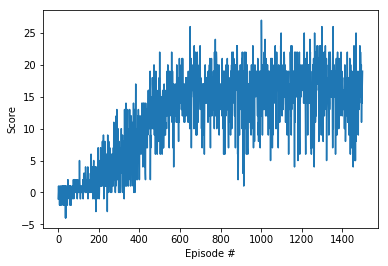

In [16]:
# simple agent with learning every 4 steps and updating target network with every 4 steps as well
hyperparams = { "BUFFER_SIZE" : int(1e5),  # replay buffer size
                "BATCH_SIZE" : 64,         # minibatch size
                "GAMMA" : 0.99,             # discount factor
                "TAU" : 1e-3,               # for soft update of target parameters
                "LR" : 5e-4,                # learning rate 
                "UPDATE_EVERY" : 5,         # how often to update the network
                "UPDATE_TARGET_EVERY" : 7   # how often to update target network 
              }

agent = DQNAgent(device, hyperparams, QNetwork, state_size=env.state_size, action_size=env.action_size, seed=0)

scores = dqn(env, agent, n_episodes=1500, model_file = 'DQN1checkpoint.pth')

np.save("DQN1Scores.npy", scores)

plot_scores(scores)

#### DQN with learning each 4 steps and target network update each 16 steps

Episode 100	Average Score: 0.37
Saving model... Episode: 100 	Average Score: 0.37

Episode 200	Average Score: 2.41
Saving model... Episode: 200 	Average Score: 2.41

Episode 300	Average Score: 8.22
Saving model... Episode: 300 	Average Score: 8.22

Episode 400	Average Score: 10.91
Saving model... Episode: 400 	Average Score: 10.91

Episode 500	Average Score: 13.16
Saving model... Episode: 500 	Average Score: 13.16

Episode 600	Average Score: 15.13
Saving model... Episode: 600 	Average Score: 15.13

Episode 700	Average Score: 15.31
Saving model... Episode: 700 	Average Score: 15.31

Episode 800	Average Score: 15.48
Saving model... Episode: 800 	Average Score: 15.48

Episode 900	Average Score: 15.89
Saving model... Episode: 900 	Average Score: 15.89

Episode 1000	Average Score: 15.70
Episode 1100	Average Score: 15.83
Episode 1200	Average Score: 15.82
Episode 1300	Average Score: 16.12
Saving model... Episode: 1300 	Average Score: 16.12

Episode 1400	Average Score: 15.17
Episode 1500	Avera

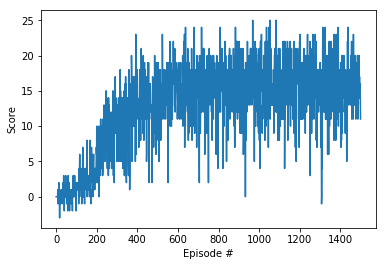

In [17]:
# simple agent with learning every 4 steps and updating target network with every 16 steps
hyperparams = { "BUFFER_SIZE" : int(1e5),  # replay buffer size
                "BATCH_SIZE" : 64,         # minibatch size
                "GAMMA" : 0.99,             # discount factor
                "TAU" : 1e-3,               # for soft update of target parameters
                "LR" : 5e-4,                # learning rate 
                "UPDATE_EVERY" : 3,         # how often to update the network
                "UPDATE_TARGET_EVERY" : 5  # how often to update target network 
              }

agent = DQNAgent(device, hyperparams, QNetwork, state_size=env.state_size, action_size=env.action_size, seed=0)

scores = dqn(env, agent, n_episodes=1500, model_file = 'DQN2checkpoint.pth')

np.save("DQN2Scores.npy", scores)

plot_scores(scores)

#### Double DQN with learning each 4 steps and target network update each 16 steps

Episode 100	Average Score: -0.05
Episode 200	Average Score: 0.252
Saving model... Episode: 200 	Average Score: 0.25

Episode 300	Average Score: 1.27
Saving model... Episode: 300 	Average Score: 1.27

Episode 400	Average Score: 2.17
Saving model... Episode: 400 	Average Score: 2.17

Episode 500	Average Score: 3.12
Saving model... Episode: 500 	Average Score: 3.12

Episode 600	Average Score: 4.26
Saving model... Episode: 600 	Average Score: 4.26

Episode 700	Average Score: 5.35
Saving model... Episode: 700 	Average Score: 5.35

Episode 800	Average Score: 5.74
Saving model... Episode: 800 	Average Score: 5.74

Episode 900	Average Score: 11.98
Saving model... Episode: 900 	Average Score: 11.98

Episode 1000	Average Score: 14.22
Saving model... Episode: 1000 	Average Score: 14.22

Episode 1100	Average Score: 15.09
Saving model... Episode: 1100 	Average Score: 15.09

Episode 1200	Average Score: 14.71
Episode 1300	Average Score: 14.69
Episode 1400	Average Score: 15.75
Saving model... Episode:

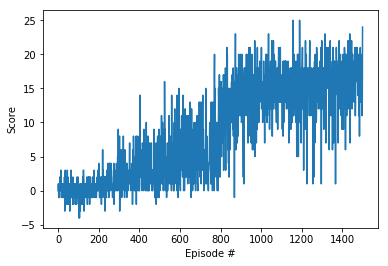

In [18]:
# DDQN agent with learning every 4 steps and updating target network with every 13 steps

# simple agent with learning every 4 steps and updating target network with every 16 steps
hyperparams = { "BUFFER_SIZE" : int(1e5),  # replay buffer size
                "BATCH_SIZE" : 64,         # minibatch size
                "GAMMA" : 0.99,             # discount factor
                "TAU" : 1e-3,               # for soft update of target parameters
                "LR" : 5e-4,                # learning rate 
                "UPDATE_EVERY" : 5,         # how often to update the network
                "UPDATE_TARGET_EVERY" : 15  # how often to update target network 
              }

agent = DDQNAgent(device, hyperparams, QNetwork, state_size=env.state_size, action_size=env.action_size, seed=0)
scores = dqn(env, agent, n_episodes=1500, model_file = 'DDQN1checkpoint.pth')

np.save("DDQN1Scores.npy", scores)

plot_scores(scores)

Episode 100	Average Score: 0.41
Saving model... Episode: 100 	Average Score: 0.41

Episode 200	Average Score: 1.30
Saving model... Episode: 200 	Average Score: 1.30

Episode 300	Average Score: 3.85
Saving model... Episode: 300 	Average Score: 3.85

Episode 400	Average Score: 7.49
Saving model... Episode: 400 	Average Score: 7.49

Episode 500	Average Score: 11.84
Saving model... Episode: 500 	Average Score: 11.84

Episode 600	Average Score: 14.06
Saving model... Episode: 600 	Average Score: 14.06

Episode 700	Average Score: 15.12
Saving model... Episode: 700 	Average Score: 15.12

Episode 800	Average Score: 15.29
Saving model... Episode: 800 	Average Score: 15.29

Episode 900	Average Score: 15.65
Saving model... Episode: 900 	Average Score: 15.65

Episode 1000	Average Score: 15.81
Saving model... Episode: 1000 	Average Score: 15.81

Episode 1100	Average Score: 16.19
Saving model... Episode: 1100 	Average Score: 16.19

Episode 1200	Average Score: 16.56
Saving model... Episode: 1200 	Aver

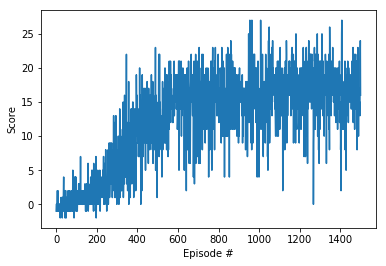

In [19]:
# Dueling DQN agent with learning every 4 steps and updating target network with every 13 steps

# simple agent with learning every 4 steps and updating target network with every 16 steps
hyperparams = { "BUFFER_SIZE" : int(1e5),  # replay buffer size
                "BATCH_SIZE" : 64,         # minibatch size
                "GAMMA" : 0.99,             # discount factor
                "TAU" : 1e-3,               # for soft update of target parameters
                "LR" : 5e-4,                # learning rate 
                "UPDATE_EVERY" : 5,         # how often to update the network
                "UPDATE_TARGET_EVERY" : 7  # how often to update target network 
              }

agent = DQNAgent(device, hyperparams, DuelingQNetwork, state_size=env.state_size, action_size=env.action_size, seed=0)
scores = dqn(env, agent, n_episodes=1500, model_file = 'DuDQN1checkpoint.pth')

np.save("DuDQN1Scores.npy", scores)

plot_scores(scores)

Episode 100	Average Score: 0.07
Saving model... Episode: 100 	Average Score: 0.07

Episode 200	Average Score: 1.31
Saving model... Episode: 200 	Average Score: 1.31

Episode 300	Average Score: 4.22
Saving model... Episode: 300 	Average Score: 4.22

Episode 400	Average Score: 7.79
Saving model... Episode: 400 	Average Score: 7.79

Episode 500	Average Score: 10.03
Saving model... Episode: 500 	Average Score: 10.03

Episode 600	Average Score: 13.03
Saving model... Episode: 600 	Average Score: 13.03

Episode 700	Average Score: 14.53
Saving model... Episode: 700 	Average Score: 14.53

Episode 800	Average Score: 17.29
Saving model... Episode: 800 	Average Score: 17.29

Episode 900	Average Score: 16.19
Episode 1000	Average Score: 16.81
Episode 1100	Average Score: 16.01
Episode 1200	Average Score: 16.20
Episode 1300	Average Score: 16.67
Episode 1400	Average Score: 17.17
Episode 1500	Average Score: 17.09


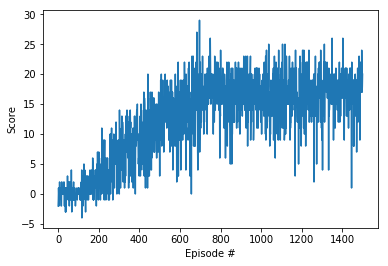

In [21]:
# Dueling DDQN agent with learning every 4 steps and updating target network with every 16 steps

# simple agent with learning every 4 steps and updating target network with every 16 steps
hyperparams = { "BUFFER_SIZE" : int(1e5),  # replay buffer size
                "BATCH_SIZE" : 64,         # minibatch size
                "GAMMA" : 0.99,             # discount factor
                "TAU" : 1e-3,               # for soft update of target parameters
                "LR" : 5e-4,                # learning rate 
                "UPDATE_EVERY" : 5,         # how often to update the network
                "UPDATE_TARGET_EVERY" : 7   # how often to update target network 
              }

agent = DDQNAgent(device, hyperparams, DuelingQNetwork, state_size=env.state_size, action_size=env.action_size, seed=0)
score = dqn(env, agent, n_episodes=1500, model_file = 'DuDDQN2checkpoint.pth')

np.save("DuDDQN2scores.npy", score)

plot_scores(score)

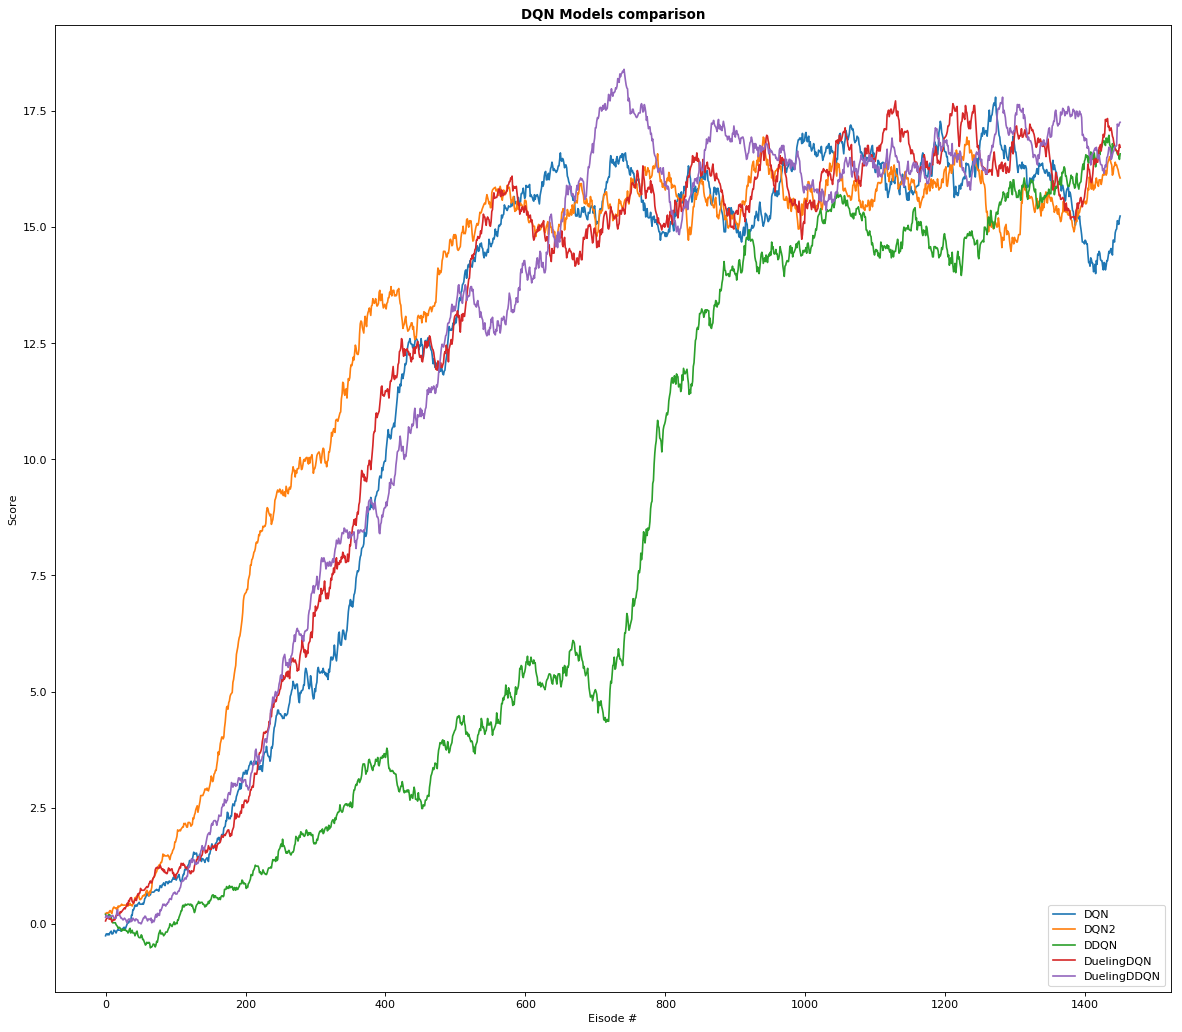

In [35]:
scores1 = np.load("DQN1Scores.npy")
scores2 = np.load("DQN2Scores.npy")
scores3 = np.load("DDQN1Scores.npy")
scores4 = np.load("DuDQN1Scores.npy")
scores5 = np.load("DuDDQN2scores.npy")

plot_comparison([scores1, scores2, scores3, scores4, scores5],  ['DQN', 'DQN2','DDQN','DuelingDQN','DuelingDDQN'], 50)

In [37]:
agent = agent
state = env.reset(False)
score = 0                                       
while True:
    action = agent.act(state, 0)                
    next_state, reward, done = env.step(action)            
    score += reward                                
    state = next_state                             
    if done:                                     
        break
    
print("Score: {}".format(score))

Score: 19.0


In [ ]:
env.close()